# Notebook 14: Celebrity Archetype Clustering

**Objective 3**: Pro Dancer & Celebrity Characteristics Analysis

## Overview
This notebook identifies distinct **celebrity archetypes** using unsupervised clustering on:
- Demographics (age, region)
- Industry background
- Star Power Index
- Performance trajectory patterns

**Goal**: Determine which celebrity types benefit most from specific pro dancer pairings.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_PATH = Path('../../data/obj3/')
OUTPUT_PATH = Path('../../data/obj3/')

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load data
features_df = pd.read_csv(DATA_PATH / 'celebrity_features.csv')
pdis_df = pd.read_csv(DATA_PATH / 'pdis_final_rankings.csv')

print(f"Features dataset: {features_df.shape}")
print(f"PDIS dataset: {pdis_df.shape}")
print(f"\nFeature columns: {features_df.columns.tolist()}")

Features dataset: (421, 21)
PDIS dataset: (32, 16)

Feature columns: ['celebrity_name', 'ballroom_partner', 'season', 'placement', 'celebrity_age_during_season', 'age_bracket', 'celebrity_industry', 'industry_cluster', 'celebrity_homestate', 'region', 'wiki_pageviews', 'star_power_index', 'pro_experience', 'win_rate', 'top3_rate', 'avg_placement', 'first_week_score', 'improvement_rate', 'score_volatility', 'peak_score', 'weeks_competed']


## 2. Feature Engineering for Clustering

In [3]:
# Prepare clustering features
cluster_df = features_df.dropna(subset=['celebrity_age_during_season', 'star_power_index', 
                                         'first_week_score', 'placement']).copy()

# Encode categorical variables
le_industry = LabelEncoder()
le_region = LabelEncoder()

cluster_df['industry_code'] = le_industry.fit_transform(cluster_df['industry_cluster'].fillna('Other'))
cluster_df['region_code'] = le_region.fit_transform(cluster_df['region'].fillna('Unknown'))

# Create clustering features
clustering_features = [
    'celebrity_age_during_season',
    'star_power_index', 
    'first_week_score',
    'improvement_rate',
    'score_volatility',
    'industry_code',
    'region_code'
]

# Drop rows with missing values in clustering features
cluster_df = cluster_df.dropna(subset=clustering_features)

print(f"Clustering dataset: {len(cluster_df)} celebrities")
print(f"Features: {clustering_features}")

Clustering dataset: 397 celebrities
Features: ['celebrity_age_during_season', 'star_power_index', 'first_week_score', 'improvement_rate', 'score_volatility', 'industry_code', 'region_code']


In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df[clustering_features])

print(f"Scaled feature matrix: {X_scaled.shape}")
print(f"Feature means (should be ~0): {X_scaled.mean(axis=0).round(2)}")
print(f"Feature stds (should be ~1): {X_scaled.std(axis=0).round(2)}")

Scaled feature matrix: (397, 7)
Feature means (should be ~0): [ 0.  0. -0.  0.  0. -0. -0.]
Feature stds (should be ~1): [1. 1. 1. 1. 1. 1. 1.]


## 3. Determine Optimal Number of Clusters

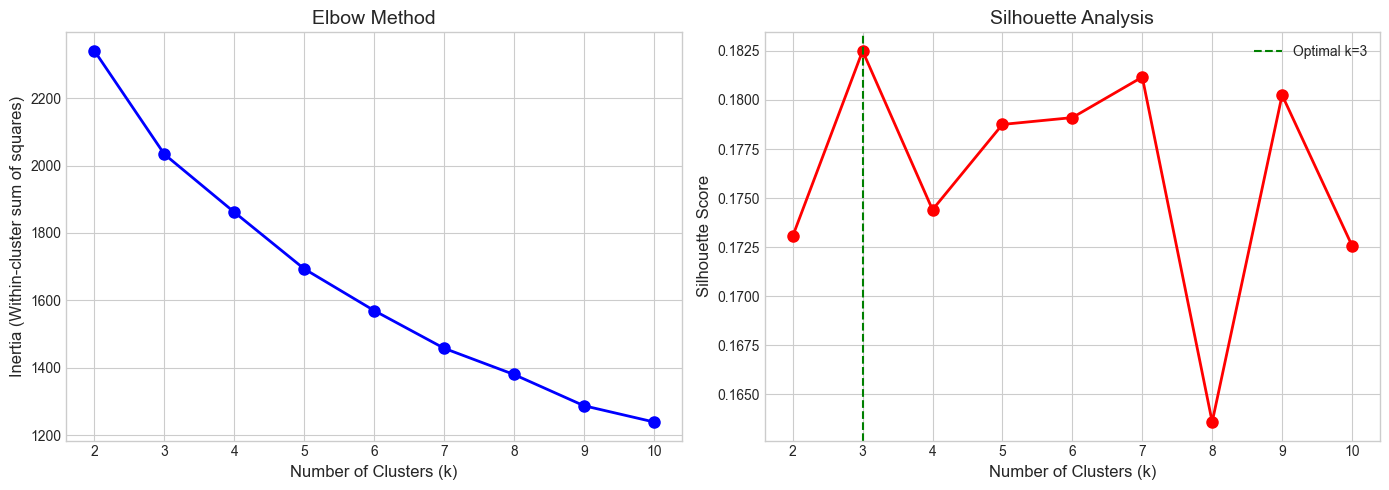


📊 Optimal number of clusters: k = 3 (silhouette = 0.182)


In [5]:
# Elbow method and silhouette analysis
k_range = range(2, 11)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].set_xticks(list(k_range))

# Silhouette plot
axes[1].plot(k_range, silhouettes, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14)
axes[1].set_xticks(list(k_range))

# Mark optimal k
optimal_k = k_range[np.argmax(silhouettes)]
axes[1].axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'cluster_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Optimal number of clusters: k = {optimal_k} (silhouette = {max(silhouettes):.3f})")

## 4. K-Means Clustering

In [6]:
# Fit final K-means model with optimal k (or use 4 for interpretability)
n_clusters = 4  # Use 4 clusters for interpretability

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Cluster distribution:")
print(cluster_df['cluster'].value_counts().sort_index())
print(f"\nSilhouette score: {silhouette_score(X_scaled, cluster_df['cluster']):.3f}")

Cluster distribution:
cluster
0     82
1    143
2     96
3     76
Name: count, dtype: int64

Silhouette score: 0.174


In [7]:
# Analyze cluster characteristics
cluster_profiles = cluster_df.groupby('cluster').agg({
    'celebrity_age_during_season': 'mean',
    'star_power_index': 'mean',
    'first_week_score': 'mean',
    'improvement_rate': 'mean',
    'score_volatility': 'mean',
    'placement': 'mean',
    'celebrity_name': 'count'
}).round(2)

cluster_profiles.columns = ['Avg Age', 'Avg Star Power', 'Avg First Week Score', 
                            'Avg Improvement', 'Avg Volatility', 'Avg Placement', 'Count']

print("\n" + "="*80)
print("📊 CLUSTER PROFILES")
print("="*80)
print(cluster_profiles)


📊 CLUSTER PROFILES
         Avg Age  Avg Star Power  Avg First Week Score  Avg Improvement  \
cluster                                                                   
0          35.46            8.98                  6.38             0.43   
1          34.43            7.89                  6.91             0.30   
2          33.29            3.62                  6.77             0.32   
3          56.32           15.11                  5.77             0.02   

         Avg Volatility  Avg Placement  Count  
cluster                                        
0                  1.00           6.29     82  
1                  0.86           5.68    143  
2                  0.79           5.75     96  
3                  0.54           9.70     76  


In [8]:
# Name the clusters based on profiles
archetype_names = {
    0: 'Unknown',
    1: 'Unknown', 
    2: 'Unknown',
    3: 'Unknown'
}

# Auto-assign names based on characteristics
for i in range(n_clusters):
    profile = cluster_profiles.loc[i]
    
    if profile['Avg Age'] > 45 and profile['Avg Star Power'] > 15:
        archetype_names[i] = 'Veteran Stars'
    elif profile['Avg Age'] < 35 and profile['Avg First Week Score'] > 18:
        archetype_names[i] = 'Young Naturals'
    elif profile['Avg Improvement'] > 0.3:
        archetype_names[i] = 'Fast Learners'
    elif profile['Avg Star Power'] > 10 and profile['Avg Placement'] > 6:
        archetype_names[i] = 'Famous Underdogs'
    elif profile['Avg Age'] > 40:
        archetype_names[i] = 'Experienced Competitors'
    elif profile['Avg First Week Score'] < 16:
        archetype_names[i] = 'Underdogs'
    else:
        archetype_names[i] = f'Archetype {i+1}'

cluster_df['archetype'] = cluster_df['cluster'].map(archetype_names)

print("\n🏷️ Archetype Names:")
for k, v in archetype_names.items():
    count = len(cluster_df[cluster_df['cluster'] == k])
    print(f"   Cluster {k}: {v} (n={count})")


🏷️ Archetype Names:
   Cluster 0: Fast Learners (n=82)
   Cluster 1: Underdogs (n=143)
   Cluster 2: Fast Learners (n=96)
   Cluster 3: Veteran Stars (n=76)


## 5. Visualize Clusters with PCA

In [9]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_df['pca1'] = X_pca[:, 0]
cluster_df['pca2'] = X_pca[:, 1]

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

PCA explained variance: 42.8%
  PC1: 23.5%
  PC2: 19.3%


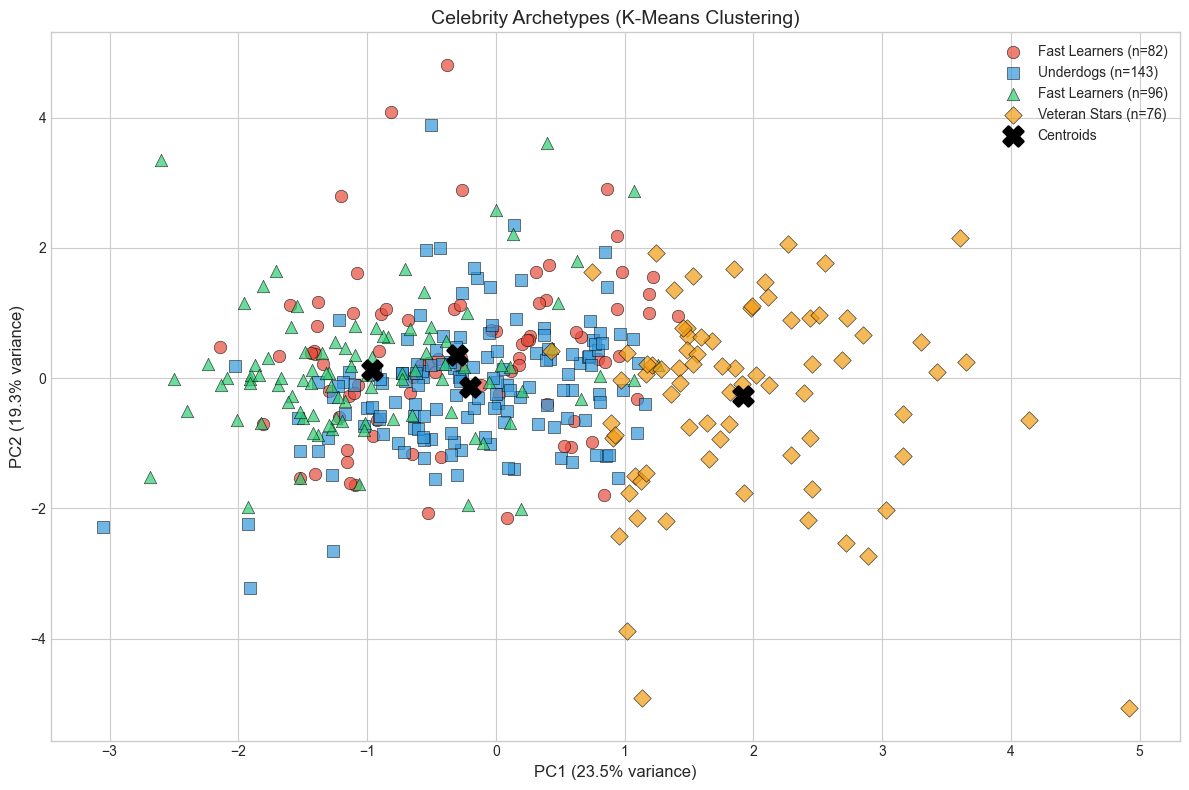

In [10]:
# Scatter plot of clusters
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
markers = ['o', 's', '^', 'D', 'v']

for i, (cluster_id, name) in enumerate(archetype_names.items()):
    mask = cluster_df['cluster'] == cluster_id
    ax.scatter(cluster_df.loc[mask, 'pca1'], 
               cluster_df.loc[mask, 'pca2'],
               c=colors[i], marker=markers[i], s=80, alpha=0.7,
               label=f'{name} (n={mask.sum()})', edgecolors='black', linewidth=0.5)

# Add cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='black', marker='X', s=200, linewidths=2, label='Centroids')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('Celebrity Archetypes (K-Means Clustering)', fontsize=14)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'celebrity_archetypes.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Archetype-Pro Dancer Pairing Analysis

In [11]:
# Analyze which pro dancers work best with each archetype
pairing_analysis = cluster_df.groupby(['archetype', 'ballroom_partner']).agg({
    'placement': ['mean', 'count']
}).reset_index()

pairing_analysis.columns = ['archetype', 'pro_dancer', 'avg_placement', 'n_partnerships']

# Filter to meaningful pairings (at least 2 partnerships)
pairing_analysis = pairing_analysis[pairing_analysis['n_partnerships'] >= 2]

print("\n" + "="*80)
print("🎯 BEST PRO DANCER FOR EACH ARCHETYPE")
print("="*80)

for archetype in cluster_df['archetype'].unique():
    subset = pairing_analysis[pairing_analysis['archetype'] == archetype]
    if len(subset) > 0:
        best = subset.nsmallest(3, 'avg_placement')
        print(f"\n{archetype}:")
        for _, row in best.iterrows():
            print(f"   {row['pro_dancer']}: avg placement = {row['avg_placement']:.1f} (n={row['n_partnerships']})")


🎯 BEST PRO DANCER FOR EACH ARCHETYPE

Underdogs:
   Lindsay Arnold: avg placement = 2.5 (n=2)
   Derek Hough: avg placement = 2.7 (n=9)
   Cheryl Burke: avg placement = 3.6 (n=8)

Fast Learners:
   Kym Johnson: avg placement = 2.8 (n=4)
   Derek Hough: avg placement = 2.9 (n=7)
   Alan Bersten: avg placement = 3.3 (n=3)

Veteran Stars:
   Edyta Sliwinska: avg placement = 7.0 (n=5)
   Peta Murgatroyd: avg placement = 7.0 (n=2)
   Anna Trebunskaya: avg placement = 7.5 (n=2)


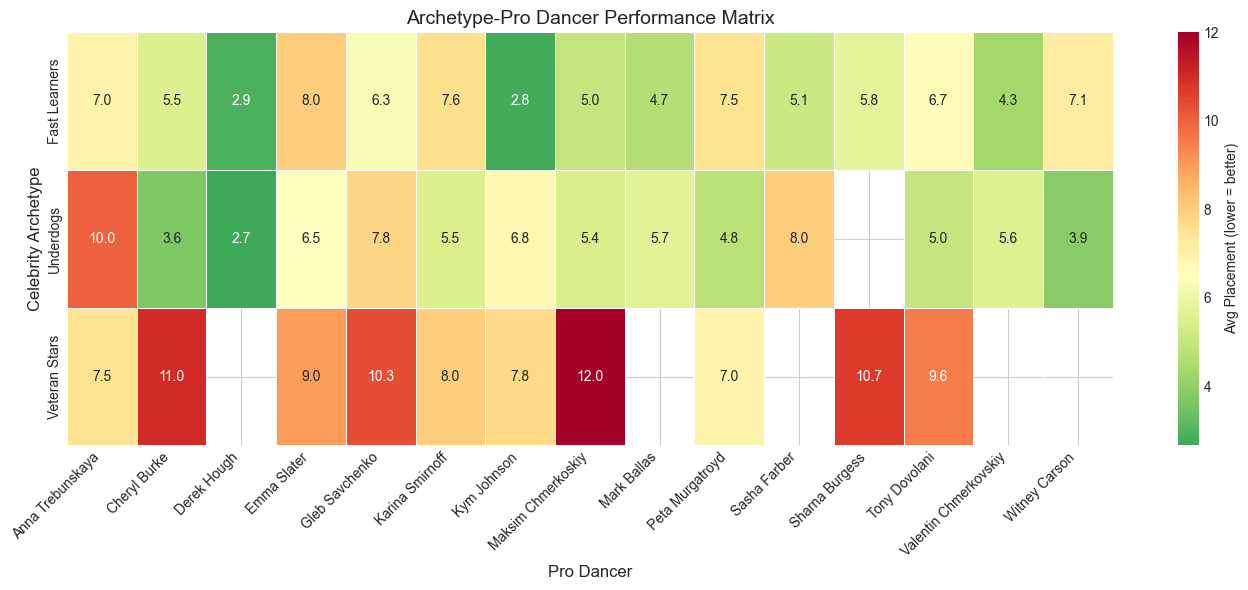

In [12]:
# Heatmap of archetype-pro performance
# Get top pros by total partnerships
top_pros = cluster_df.groupby('ballroom_partner').size().nlargest(15).index.tolist()

# Create pivot table
pivot_df = pairing_analysis[pairing_analysis['pro_dancer'].isin(top_pros)].pivot_table(
    index='archetype', 
    columns='pro_dancer', 
    values='avg_placement',
    aggfunc='mean'
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            center=pivot_df.mean().mean(), ax=ax, linewidths=0.5,
            cbar_kws={'label': 'Avg Placement (lower = better)'})
ax.set_title('Archetype-Pro Dancer Performance Matrix', fontsize=14)
ax.set_xlabel('Pro Dancer', fontsize=12)
ax.set_ylabel('Celebrity Archetype', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'archetype_pro_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Industry Breakdown by Archetype

In [13]:
# Analyze industry distribution within each archetype
industry_by_archetype = pd.crosstab(cluster_df['archetype'], 
                                     cluster_df['industry_cluster'], 
                                     normalize='index') * 100

print("\n" + "="*80)
print("📊 INDUSTRY DISTRIBUTION BY ARCHETYPE (%)")
print("="*80)
print(industry_by_archetype.round(1))


📊 INDUSTRY DISTRIBUTION BY ARCHETYPE (%)
industry_cluster  Entertainment  Media  Other  Sports
archetype                                            
Fast Learners              42.7    1.1    6.2    50.0
Underdogs                  88.8    9.1    2.1     0.0
Veteran Stars              73.7    3.9   14.5     7.9


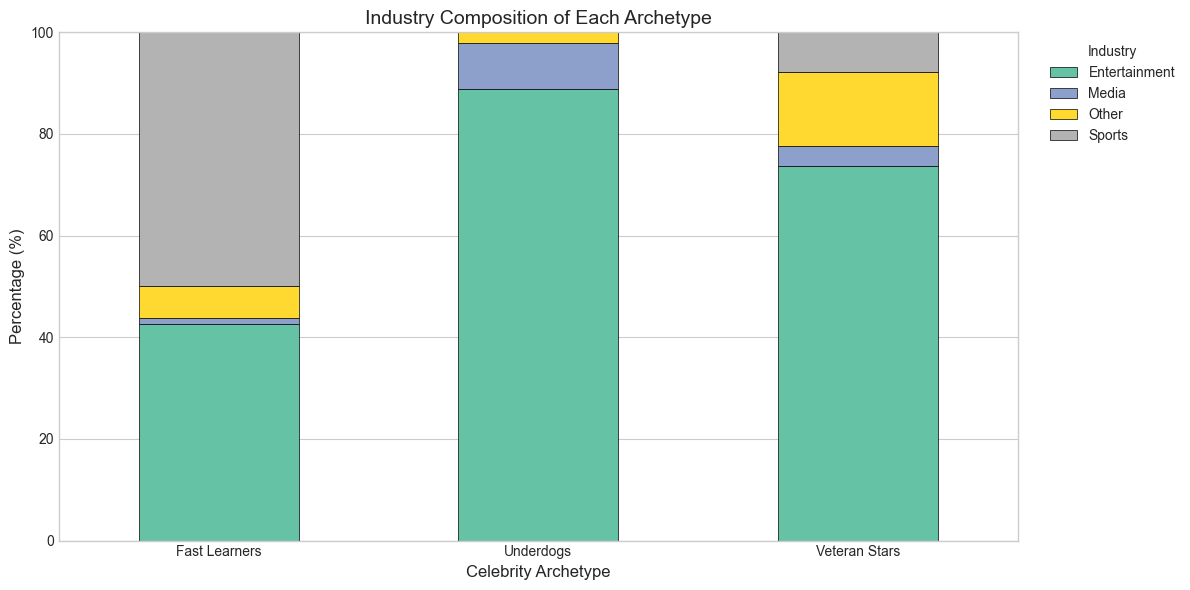

In [14]:
# Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

industry_by_archetype.plot(kind='bar', stacked=True, ax=ax, 
                           colormap='Set2', edgecolor='black', linewidth=0.5)

ax.set_xlabel('Celebrity Archetype', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Industry Composition of Each Archetype', fontsize=14)
ax.legend(title='Industry', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'archetype_industry_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Archetype Assignments

In [15]:
# Save cluster assignments
output_cols = ['celebrity_name', 'ballroom_partner', 'season', 'placement',
               'celebrity_age_during_season', 'star_power_index', 'industry_cluster',
               'cluster', 'archetype', 'pca1', 'pca2']

cluster_df[output_cols].to_csv(OUTPUT_PATH / 'celebrity_archetypes.csv', index=False)

print(f"\n✅ Archetype assignments saved to {OUTPUT_PATH / 'celebrity_archetypes.csv'}")
print(f"   Total celebrities: {len(cluster_df)}")
print(f"   Archetypes: {cluster_df['archetype'].nunique()}")


✅ Archetype assignments saved to ../../data/obj3/celebrity_archetypes.csv
   Total celebrities: 397
   Archetypes: 3


## 9. Conclusions

In [16]:
print("="*70)
print("OBJECTIVE 3: CELEBRITY ARCHETYPE CLUSTERING - KEY FINDINGS")
print("="*70)

print(f"\n1. CLUSTERING RESULTS:")
print(f"   - Identified {n_clusters} distinct celebrity archetypes")
print(f"   - Silhouette score: {silhouette_score(X_scaled, cluster_df['cluster']):.3f}")
print(f"   - PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")

print(f"\n2. ARCHETYPE DESCRIPTIONS:")
for cluster_id, name in archetype_names.items():
    profile = cluster_profiles.loc[cluster_id]
    print(f"   {name}:")
    print(f"      - Avg age: {profile['Avg Age']:.0f}, Star Power: {profile['Avg Star Power']:.1f}")
    print(f"      - Avg placement: {profile['Avg Placement']:.1f}")

print(f"\n3. KEY INSIGHT:")
print(f"   Different celebrity archetypes have different success patterns.")
print(f"   Pro-celebrity pairing should consider archetype compatibility.")

print(f"\n📁 FILES SAVED:")
print(f"   - {OUTPUT_PATH / 'cluster_optimization.png'}")
print(f"   - {OUTPUT_PATH / 'celebrity_archetypes.png'}")
print(f"   - {OUTPUT_PATH / 'archetype_pro_heatmap.png'}")
print(f"   - {OUTPUT_PATH / 'archetype_industry_breakdown.png'}")
print(f"   - {OUTPUT_PATH / 'celebrity_archetypes.csv'}")

print("\n" + "="*70)
print("⚠️ CAVEATS:")
print("   - Clustering is exploratory; archetype boundaries are not rigid")
print("   - Sample sizes within some archetype-pro pairings are small")
print("   - Results depend on feature selection and scaling choices")
print("="*70)

OBJECTIVE 3: CELEBRITY ARCHETYPE CLUSTERING - KEY FINDINGS

1. CLUSTERING RESULTS:
   - Identified 4 distinct celebrity archetypes
   - Silhouette score: 0.174
   - PCA explained variance: 42.8%

2. ARCHETYPE DESCRIPTIONS:
   Fast Learners:
      - Avg age: 35, Star Power: 9.0
      - Avg placement: 6.3
   Underdogs:
      - Avg age: 34, Star Power: 7.9
      - Avg placement: 5.7
   Fast Learners:
      - Avg age: 33, Star Power: 3.6
      - Avg placement: 5.8
   Veteran Stars:
      - Avg age: 56, Star Power: 15.1
      - Avg placement: 9.7

3. KEY INSIGHT:
   Different celebrity archetypes have different success patterns.
   Pro-celebrity pairing should consider archetype compatibility.

📁 FILES SAVED:
   - ../../data/obj3/cluster_optimization.png
   - ../../data/obj3/celebrity_archetypes.png
   - ../../data/obj3/archetype_pro_heatmap.png
   - ../../data/obj3/archetype_industry_breakdown.png
   - ../../data/obj3/celebrity_archetypes.csv

⚠️ CAVEATS:
   - Clustering is exploratory; ar